[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1319777262.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_y_lim = min(float(vix_data['Close'].min()), soglia_vix_bassa)


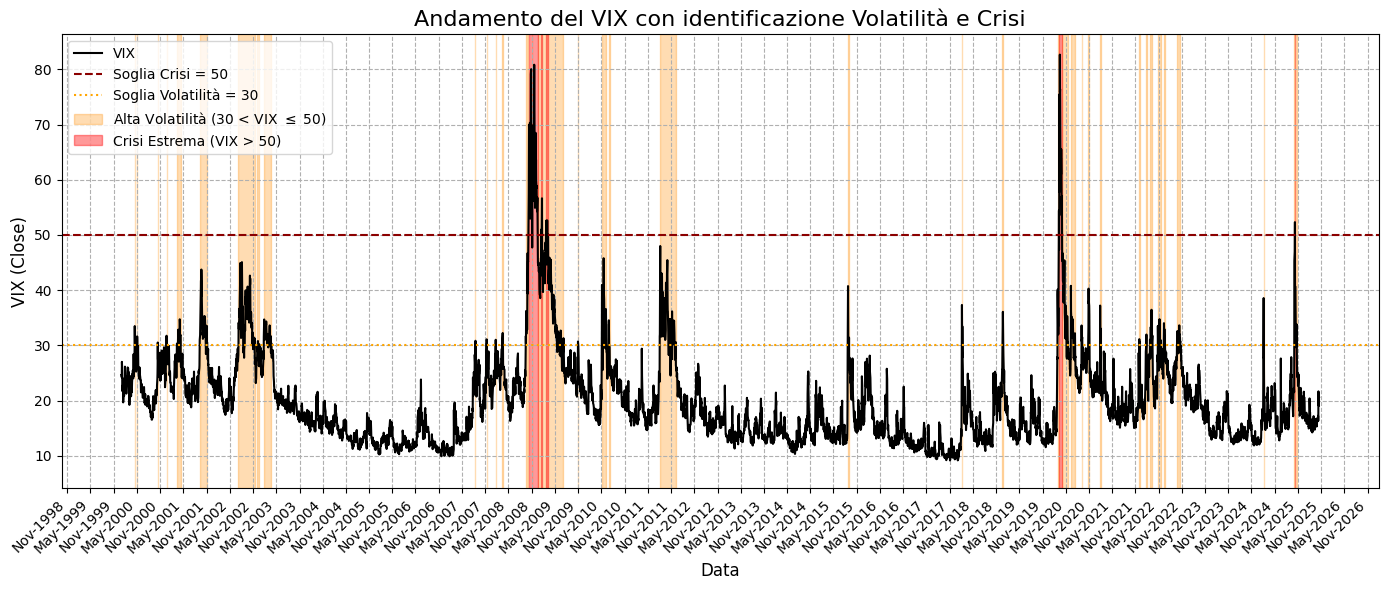


Tabella dei periodi di Alta Volatilità (macro, 30 < VIX <= 50):
       Inizio       Fine
0  2000-04-14 2000-04-16
1  2000-05-03 2000-05-04
2  2000-10-12 2000-10-12
3  2000-12-20 2000-12-20
4  2001-03-12 2001-04-09
5  2001-09-07 2001-11-05
6  2002-07-09 2002-11-13
7  2002-12-05 2002-12-19
8  2003-01-24 2003-03-24
9  2007-08-15 2007-08-16
10 2007-11-12 2007-11-12
11 2008-01-22 2008-01-22
12 2008-03-14 2008-03-17
13 2008-09-15 2008-10-05
14 2008-11-04 2008-11-04
15 2008-12-17 2009-07-08
16 2009-10-30 2009-11-01
17 2010-05-06 2010-06-10
18 2010-06-29 2010-07-05
19 2011-08-04 2011-12-08
20 2015-08-24 2015-09-01
21 2018-02-05 2018-02-08
22 2018-12-21 2018-12-26
23 2020-02-27 2020-03-10
24 2020-04-03 2020-05-19
25 2020-06-11 2020-07-13
26 2020-09-03 2020-09-08
27 2020-10-26 2020-11-03
28 2021-01-27 2021-02-01
29 2021-12-01 2021-12-05
30 2022-01-25 2022-01-27
31 2022-02-23 2022-03-14
32 2022-04-26 2022-05-18
33 2022-06-13 2022-06-21
34 2022-09-26 2022-10-19
35 2024-08-05 2024-08-05
36 2025-04

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import matplotlib.dates as mdates

vix_data = yf.download("^VIX", start="1999-12-31", auto_adjust=True)

# identificazione soglie
soglia_vix_alta = 50
soglia_vix_bassa = 30

# analisi soglia VIX alta
vix_data['Crisis_Period_High'] = vix_data['Close'] > soglia_vix_alta

periodi_crisi_estrema = []
inizio_crisi = None

for data, crisi in zip(vix_data.index, vix_data['Crisis_Period_High']):
    if crisi and inizio_crisi is None:
        inizio_crisi = data
    elif not crisi and inizio_crisi is not None:
        fine_crisi = data - pd.Timedelta(days=1)
        periodi_crisi_estrema.append((inizio_crisi, fine_crisi))
        inizio_crisi = None

if inizio_crisi is not None:
    periodi_crisi_estrema.append((inizio_crisi, vix_data.index[-1]))

gap_max = pd.Timedelta(days=15)
periodi_crisi_macro_estrema = []

if periodi_crisi_estrema:
    inizio, fine = periodi_crisi_estrema[0]
    for curr_inizio, curr_fine in periodi_crisi_estrema[1:]:
        if (curr_inizio - fine) <= gap_max:
            fine = curr_fine
        else:
            periodi_crisi_macro_estrema.append((inizio, fine))
            inizio, fine = curr_inizio, curr_fine
    periodi_crisi_macro_estrema.append((inizio, fine))
else:
    periodi_crisi_macro_estrema = periodi_crisi_estrema

# analisi soglia VIX bassa
vix_data['Volatile_Period'] = (vix_data['Close'] > soglia_vix_bassa) & (vix_data['Close'] <= soglia_vix_alta)

periodi_volatile = []
inizio_volatile = None

for data, volatile in zip(vix_data.index, vix_data['Volatile_Period']):
    if volatile and inizio_volatile is None:
        inizio_volatile = data
    elif not volatile and inizio_volatile is not None:
        fine_volatile = data - pd.Timedelta(days=1)
        periodi_volatile.append((inizio_volatile, fine_volatile))
        inizio_volatile = None

if inizio_volatile is not None:
    periodi_volatile.append((inizio_volatile, vix_data.index[-1]))

periodi_volatile_macro = []
if periodi_volatile:
    inizio, fine = periodi_volatile[0]
    for curr_inizio, curr_fine in periodi_volatile[1:]:
        if (curr_inizio - fine) <= gap_max:
            fine = curr_fine
        else:
            periodi_volatile_macro.append((inizio, fine))
            inizio, fine = curr_inizio, curr_fine
    periodi_volatile_macro.append((inizio, fine))
else:
    periodi_volatile_macro = periodi_volatile


# Plot grafico
plt.figure(figsize=(14,6))
plt.plot(vix_data.index, vix_data['Close'], label='VIX', color='black', linewidth=1.5)

plt.axhline(y=soglia_vix_alta, color='darkred', linestyle='--', linewidth=1.5, label=f'Soglia Crisi = {soglia_vix_alta}')
plt.axhline(y=soglia_vix_bassa, color='orange', linestyle=':', linewidth=1.5, label=f'Soglia Volatilità = {soglia_vix_bassa}')


for i, (inizio, fine) in enumerate(periodi_volatile_macro):
    label = r'Alta Volatilità (30 < VIX $\leq$ 50)' if i == 0 else ""
    plt.axvspan(inizio, fine, color='darkorange', alpha=0.3, label=label)

for i, (inizio, fine) in enumerate(periodi_crisi_macro_estrema):
    label = 'Crisi Estrema (VIX > 50)' if i == 0 else ""
    plt.axvspan(inizio, fine, color='red', alpha=0.4, label=label)


plt.title("Andamento del VIX con identificazione Volatilità e Crisi", fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('VIX (Close)', fontsize=12)


ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45, ha='right')


min_y_lim = min(float(vix_data['Close'].min()), soglia_vix_bassa)
plt.ylim(bottom=max(0, min_y_lim - 5))

plt.legend(loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

# Tabella finale per i periodi di crisi
print("\nTabella dei periodi di Alta Volatilità (macro, 30 < VIX <= 50):")
df_volatile_macro = pd.DataFrame(periodi_volatile_macro, columns=['Inizio', 'Fine'])
print(df_volatile_macro)

print("\nTabella dei periodi di Crisi Estrema (macro, VIX > 50):")
df_crisi_macro_estrema = pd.DataFrame(periodi_crisi_macro_estrema, columns=['Inizio', 'Fine'])
print(df_crisi_macro_estrema)